# 🗂️ Trip Duration Prediction Project
**Goal:** Predict the duration of NYC taxi trips using Linear Regression.

In [ ]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
# 📥 2. Load and Explore the Dataset
df = pd.read_csv("C:\\ID\\train.csv")

print("Initial shape:", df.shape)
df.head()

In [ ]:
# 📊 3. Basic Info & Statistics
df.info()
df.describe()

In [ ]:
# 🧹 4. Data Cleaning

df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 10800)]
df = df[
    (df['pickup_longitude'].between(-75, -72)) &
    (df['dropoff_longitude'].between(-75, -72)) &
    (df['pickup_latitude'].between(40, 42)) &
    (df['dropoff_latitude'].between(40, 42))
]

print("Remaining rows after cleaning:", len(df))

In [ ]:
# 📈 5. Exploratory Data Analysis (EDA)

# 1 - Histogram for Trip Duration Distribution (Raw)
sns.histplot(df['trip_duration'], bins=100, kde=True)
plt.title('Trip Duration Distribution')
plt.show()

#### 🔍 My Observations:
The distribution of `trip_duration` is highly right-skewed, indicating a long tail of unusually long trips.This skew can negatively affect models sensitive to distribution shape. Transformation is appropriate.

In [ ]:
# 2 - Boxplot for Trip Duration (Outlier Detection)
sns.boxplot(x=df['trip_duration'])
plt.title('Trip Duration Boxplot')
plt.show()

#### 🔍 My Observations:
The boxplot shows multiple outliers in `trip_duration`, suggesting the need for capping or filtering. These outliers likely reflect rare long trips or anomalies.

In [ ]:
# 3 - Histogram for Log-Transformed Trip Duration
sns.histplot(np.log1p(df['trip_duration']), bins=50, kde=True)
plt.title('Log Trip Duration Distribution')
plt.show()

#### 🔍 My Observations:
Applying `log1p` to trip duration normalizes the distribution significantly, making it more Gaussian. This is beneficial for linear models like Linear Regression.

In [ ]:
# 4 - Boxplot: Trip Duration by Vendor ID
sns.boxplot(data=df, x="vendor_id", y="trip_duration")
plt.ylim(0, 3000)
plt.title('Trip Duration by Vendor ID')
plt.show()

#### 🔍 My Observations:
Trip durations differ slightly across vendors, but overall variance is not large. Both vendors show similar central tendency, suggesting vendor_id might have low predictive power alone.

In [ ]:
# 5 - Boxplot: Trip Duration by Passenger Count
sns.boxplot(data=df, x="passenger_count", y="trip_duration")
plt.ylim(0, 3000)
plt.title('Trip Duration by Passenger Count')
plt.show()

#### 🔍 My Observations:
Most trips are made with 1-2 passengers. The duration doesn't vary much with passenger count, indicating this feature may have limited impact on prediction.

In [ ]:
# 🕓 6. Date/Time Feature Engineering

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['pickup_weekday'].apply(lambda x: 1 if x >= 5 else 0)

def get_time_of_day(hour):
    if 0 <= hour <= 5:
        return 'night'
    elif 6 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 17:
        return 'afternoon'
    else:
        return 'evening'

df['time_of_day'] = df['pickup_hour'].apply(get_time_of_day)
df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True)

In [ ]:
# 📍 7. Distance Calculation

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

sns.scatterplot(data=df.sample(10000), x='distance_km', y='trip_duration', alpha=0.3)
plt.ylim(0, 5000)
plt.title("Trip Duration vs Distance")
plt.show()

#### 🔍 My Observations:
There's a strong positive correlation between `distance_km` and `trip_duration`, as expected. Some variability at short distances could be due to traffic, stops, or outliers.

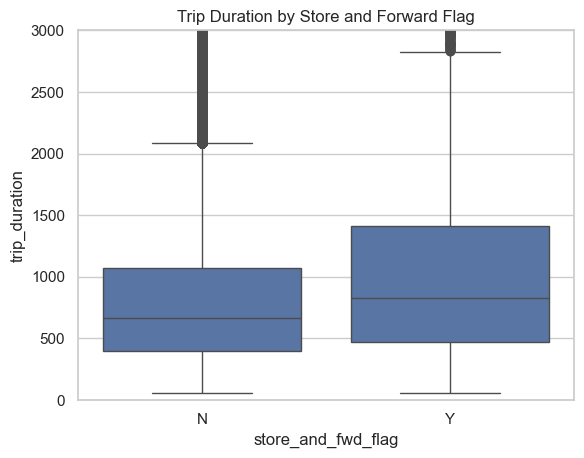

In [32]:
# 🔎 8. Additional EDA

# 1 - Boxplot: Trip Duration by Store and Forward Flag
sns.boxplot(data=df, x='store_and_fwd_flag', y='trip_duration')
plt.ylim(0, 3000)
plt.title("Trip Duration by Store and Forward Flag")
plt.show()


#### 🔍 My Observations:
`store_and_fwd_flag` appears to have little effect on trip duration. Most values are 'N'. Could be safe to include but not a strong predictor.

In [ ]:
# 2 - Correlation Heatmap of Numerical Features
numeric_cols = ['passenger_count', 'trip_duration', 'distance_km', 'pickup_hour', 'pickup_weekday', 'pickup_month']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#### 🔍 My Observations:
Strong correlation between `distance_km` and `trip_duration`.Time-based features show weaker correlations, indicating they may act more as secondary predictors.

In [ ]:
# 🧹 9. Preprocessing & Feature Engineering

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
df['log_trip_duration'] = np.log1p(df['trip_duration'])

scaler = StandardScaler()
num_features = ['distance_km', 'pickup_hour', 'pickup_weekday', 'pickup_month']
df[num_features] = scaler.fit_transform(df[num_features])

df['pickup_hour_sin'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['pickup_hour_cos'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)

df['distance_bin'] = pd.cut(df['distance_km'], bins=[0, 2, 5, 10, 20, 50], 
                            labels=['very_short', 'short', 'medium', 'long', 'very_long'])
df = pd.get_dummies(df, columns=['distance_bin'], drop_first=True)


In [ ]:
# 🧠 10. Define Features & Train/Test Split

features = [
    'distance_km', 'pickup_hour', 'pickup_weekday', 'pickup_month',
    'store_and_fwd_flag', 'is_weekend'
]
features += [col for col in df.columns if col.startswith('time_of_day_') or col.startswith('distance_bin_')]

X = df[features]
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 🔁 11. Train Linear Regression Model

model = LinearRegression()
model.fit(X_train, y_train)
model.intercept_, model.coef_

In [ ]:
# 📈 12. Evaluate Model

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE (log):", mae)
print("RMSE (log):", rmse)
print("R² Score:", r2)

In [ ]:
## 📊 13. Visualize Prediction Error

# Convert log-transformed predictions and actual values back to original scale
y_test_actual = np.expm1(y_test)     # Reverse log1p transformation
y_pred_actual = np.expm1(y_pred)     # Reverse log1p transformation

# Calculate percentage error for each test data point
percentage_errors = np.abs((y_test_actual - y_pred_actual) / y_test_actual) * 100

# Plot percentage error per data point in the test set
plt.figure(figsize=(14, 6))
plt.scatter(range(len(percentage_errors)), percentage_errors, 
            alpha=0.4, color='purple', s=10)
plt.title('Percentage Error per Data Point (Test Set)', fontsize=14)
plt.xlabel('Data Point Index')
plt.ylabel('Percentage Error (%)')
plt.grid(True)
plt.show()



In [ ]:
## 📉 14. Remove Outliers from Error 

# Step 1: Convert predicted and true values back from log scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Step 2: Calculate the absolute percentage error for each data point
percentage_errors = np.abs((y_test_actual - y_pred_actual) / y_test_actual) * 100

# Step 3: Compute the Interquartile Range (IQR)
Q1 = np.percentile(percentage_errors, 25)
Q3 = np.percentile(percentage_errors, 75)
IQR = Q3 - Q1

# Step 4: Define bounds to detect outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 5: Filter out percentage errors that fall outside the acceptable range
filtered_errors = percentage_errors[(percentage_errors >= lower_bound) & (percentage_errors <= upper_bound)]

# Step 6: Visualize the filtered percentage errors
plt.figure(figsize=(14, 6))
plt.scatter(range(len(filtered_errors)), filtered_errors, alpha=0.4, color='green', s=10)
plt.title('Filtered Percentage Error per Data Point (No Outliers)', fontsize=14)
plt.xlabel('Data Point Index')
plt.ylabel('Percentage Error (%)')
plt.grid(True)
plt.show()




In [ ]:
# 💾 13. Save Model & Features

features_used = X_train.columns.tolist()
joblib.dump(model, 'model.pkl')
joblib.dump(features_used, 'features_used.pkl')
# Calculate and save the average trip duration in seconds
avg_duration = df['trip_duration'].mean()
joblib.dump(avg_duration, 'avg_duration.pkl')

# ✅ Final Project Summary

### ✅ Strengths:
- The pipeline is complete and covers all key ML steps.
- EDA is rich, with visualizations for distributions, relationships, and correlations.
- Feature engineering includes datetime extraction, Haversine distance, and cyclical encoding.
- Proper normalization and dummy encoding are applied.
- Log transformation improves model handling of skewed data.
- Model performance is assessed with standard metrics.
- Streamlit-ready: includes model/feature export and average trip duration.

### ⚠️ Suggestions for Improvement:
- Could consider using `Ridge` or `Lasso` regression to improve generalization (LinearRegression has no regularization).
- Consider removing or capping extreme distance values (a few may still be anomalies).
- Add cross-validation for more robust evaluation.
- Track training time if deploying at scale.

### 📢 Verdict:
**This project is professionally structured and is ready for portfolio or public publishing.** 
Add a brief README with key findings, sample predictions, and Streamlit usage, and you're good to go!
